In [9]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

In [10]:
# Rutas de las carpetas de entrenamiento, predicción y test
training_path = 'training'
test_path = 'test'
prediction_path = 'prediction'

In [11]:
# Aumentación de datos
datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 10,
							width_shift_range = 0.2,
							height_shift_range = 0.2,
							shear_range = 0.3,
							zoom_range = 0.3,
							horizontal_flip = True)

Found 14034 images belonging to 6 classes.


<Figure size 640x480 with 0 Axes>

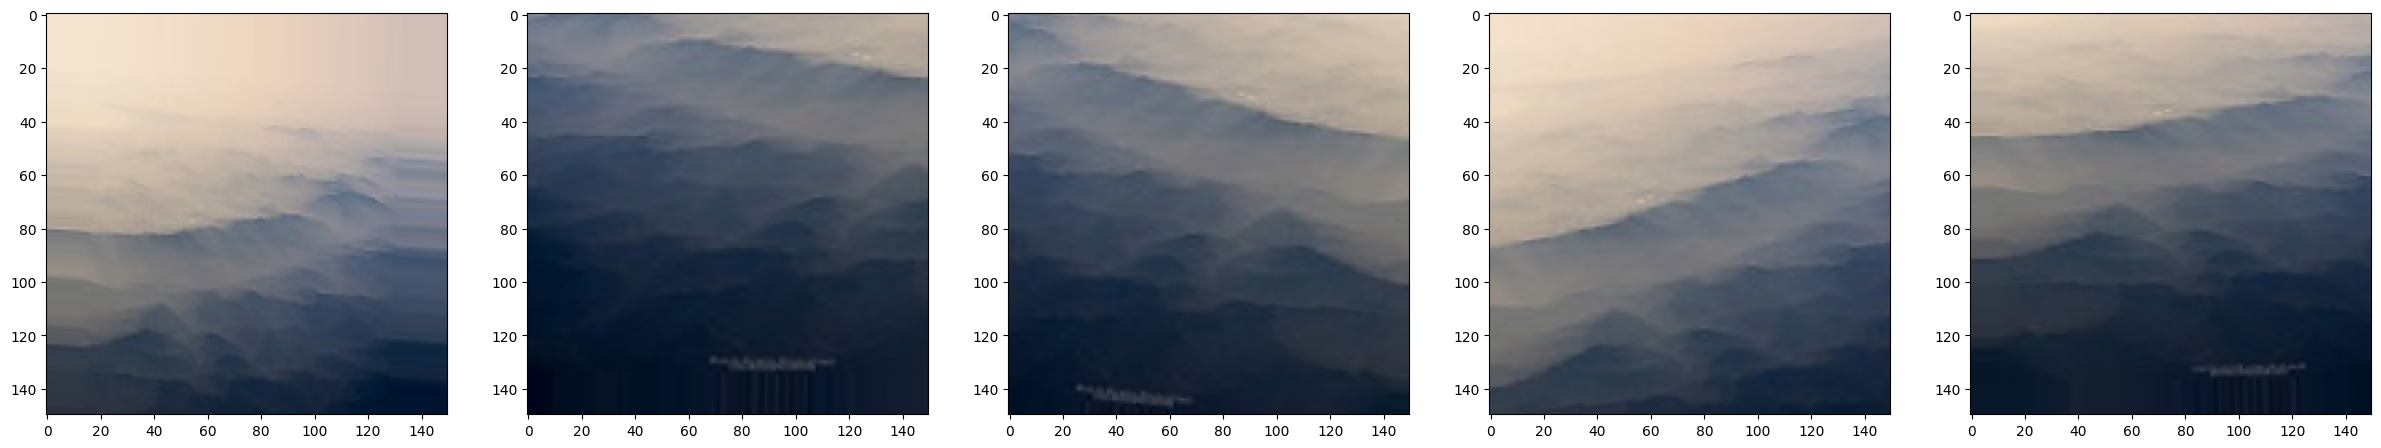

In [12]:
# Se crea un generador de datos a partir de un directorio de entrenamiento
train_generator = datagen.flow_from_directory(
							training_path,
							target_size = (150, 150),
							batch_size = 1,
							class_mode ='binary',
							)

# Crear un plt para mostrar las imágenes
plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

# Iterar sobre las primeras 5 imágenes del generador y mostrarlas
for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

Found 14034 images belonging to 6 classes.
(8, 150, 150, 3)
[1. 0. 1. 4. 5. 1. 4. 5.]


<Figure size 640x480 with 0 Axes>

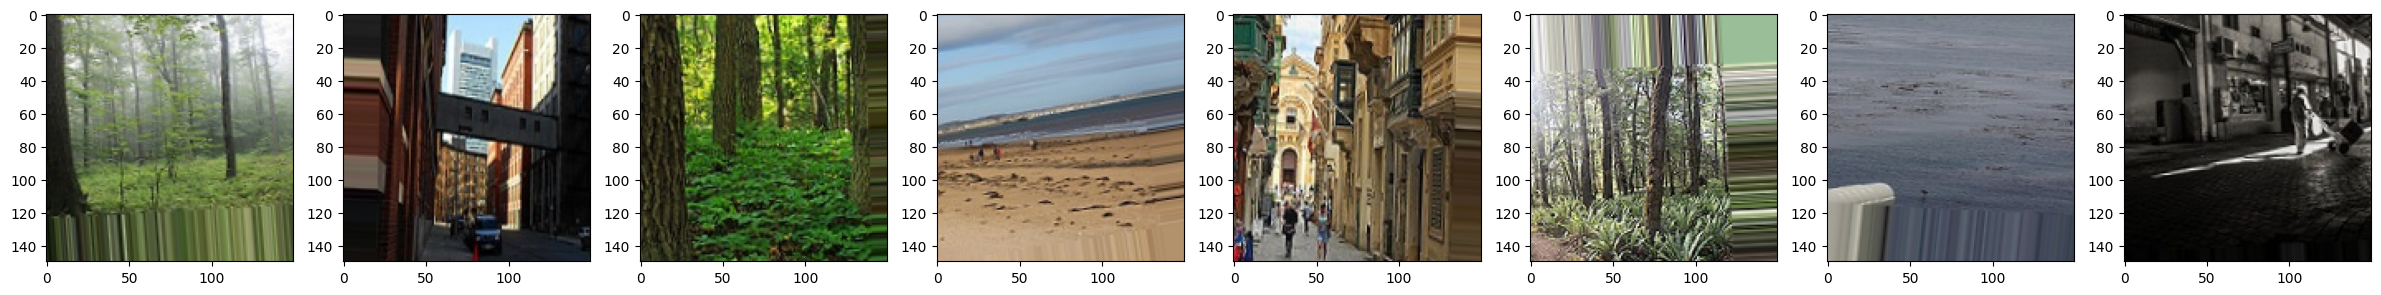

In [13]:
# Directorio donde se guardarán las imágenes aumentadas
save_dir = "augmented"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

train_generator = datagen.flow_from_directory(
							training_path,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							save_to_dir= save_dir,
              save_prefix='aug',
              save_format='png'
							)

images , labels = train_generator[0]

print(images.shape)
print(labels)
plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]) :
  axarr[i].imshow(images[i])
  
# Guardar las imágenes aumentadas
for i, _ in enumerate(train_generator): 
    if i >= 8: 
        break

In [20]:
# Crear un generador de datos a partir del directorio de testing
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='sparse'
)

Found 3000 images belonging to 6 classes.


In [21]:
# Cargar el modelo ResNet50 preentrenado en ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Añadir una capa de pooling global, una capa densa para la clasificación y una capa de salida.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x) 
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

In [22]:
# Crear el modelo final congelando las capas del modelo
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])  # Cambiar a 'sparse_categorical_crossentropy'
# Entrenar el modelo
model.fit(train_generator, epochs=10, validation_data=test_generator)

Epoch 1/10


c:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1755/1755 ━━━━━━━━━━━━━━━━━━━━ 370s 207ms/step - accuracy: 0.3237 - loss: 1.5786 - val_accuracy: 0.4283 - val_loss: 1.2860
Epoch 2/10
1116/1755 ━━━━━━━━━━━━━━━━━━━━ 1:55 181ms/step - accuracy: 0.4661 - loss: 1.2679Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\la_pa\AppData\Local\Temp\ipykernel_13080\881639648.py", line 12, in <module>
    model.fit(train_generator, epochs=10, validation_data=test_generator)
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 314, in fit
    logs = self.train_function(iterator)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\la_pa\AppData\Roaming\Python\Python311\site-packages\tensorflow\python\util\traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
 

In [ ]:
# Evaluar el modelo en el conjunto de datos de prueba
loss, accuracy = model.evaluate(test_generator)
print(f'Loss: {loss}, Accuracy: {accuracy}')